In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True}
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)


In [3]:
# class Encoder(nn.Module):
#     def __init__(self, latent_dim):
#         self.latent_dim = latent_dim
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 20, 5, 1)
#         self.conv2 = nn.Conv2d(20, 50, 5, 1)
#         self.fc1 = nn.Linear(4 * 4 * 50, 256)
#         self.mu = nn.Linear(256, self.latent_dim)
#         self.logvar = nn.Linear(256, self.latent_dim)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2, 2)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         mu = self.mu(x)
#         logvar = self.logvar(x)
#         return mu, logvar

# class Decoder(nn.Module):
#     def __init__(self, latent_dim):
#         self.latent_dim = latent_dim
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(self.latent_dim, 256)
#         self.fc2 = nn.Linear(256, 4 * 4 * 50)
#         self.conv1 = nn.ConvTranspose2d(50, 20, 5, 1)
#         self.conv2 = nn.ConvTranspose2d(20, 1, 5, 1)

#     def forward(self, x):
#         x = x.view(x.size(0), size, 1, 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = x.view(-1, 50, 4, 4)
#         x = F.relu(self.conv1(x))
#         x = F.sigmoid(self.conv2(x))
#         return x

latent_dim = 2
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
class Predictor(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, mu):
        mu = F.relu(self.fc1(mu))
        mu = F.relu(self.fc2(mu))
        mu = self.fc3(mu)
        return mu




# model = CVAE(latent_dim=2).to(device)



# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def predictor_loss(pred, target):
    # MSE
    return F.mse_loss(pred, target)


In [5]:
model = VAE().to(device)
predictor = Predictor(latent_dim=2).to(device)
optimizer = optim.AdamW(list(model.parameters()) + list(predictor.parameters()), lr=1e-3)

In [6]:
epochs = 10
log_interval = 10
batch_size = 128

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device).to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_vae = loss_function(recon_batch, data, mu, logvar)
        loss_predictor = predictor_loss(predictor(mu), label)
        loss = loss_vae + 20*loss_predictor
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')

C:\Users\liamt\AppData\Local\Temp\ipykernel_18476\1160126695.py:35: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, target)


Train Epoch: 1 [0/60000 (0%)]	Loss: 551.575928
Train Epoch: 1 [1280/60000 (2%)]	Loss: 264.178253
Train Epoch: 1 [2560/60000 (4%)]	Loss: 236.264771
Train Epoch: 1 [3840/60000 (6%)]	Loss: 211.348251
Train Epoch: 1 [5120/60000 (9%)]	Loss: 213.316345
Train Epoch: 1 [6400/60000 (11%)]	Loss: 213.047745
Train Epoch: 1 [7680/60000 (13%)]	Loss: 188.455032
Train Epoch: 1 [8960/60000 (15%)]	Loss: 196.395233
Train Epoch: 1 [10240/60000 (17%)]	Loss: 209.598938
Train Epoch: 1 [11520/60000 (19%)]	Loss: 194.761673
Train Epoch: 1 [12800/60000 (21%)]	Loss: 194.034088
Train Epoch: 1 [14080/60000 (23%)]	Loss: 194.251938
Train Epoch: 1 [15360/60000 (26%)]	Loss: 187.878891
Train Epoch: 1 [16640/60000 (28%)]	Loss: 184.227844
Train Epoch: 1 [17920/60000 (30%)]	Loss: 188.603104
Train Epoch: 1 [19200/60000 (32%)]	Loss: 184.810608
Train Epoch: 1 [20480/60000 (34%)]	Loss: 179.468613
Train Epoch: 1 [21760/60000 (36%)]	Loss: 178.759003
Train Epoch: 1 [23040/60000 (38%)]	Loss: 187.455185
Train Epoch: 1 [24320/60000 

C:\Users\liamt\AppData\Local\Temp\ipykernel_18476\1160126695.py:35: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, target)


====> Epoch: 1 Average loss: 191.3100
====> Test set loss: 171.4893
Train Epoch: 2 [0/60000 (0%)]	Loss: 171.668503
Train Epoch: 2 [1280/60000 (2%)]	Loss: 173.389954
Train Epoch: 2 [2560/60000 (4%)]	Loss: 177.529388
Train Epoch: 2 [3840/60000 (6%)]	Loss: 175.230484
Train Epoch: 2 [5120/60000 (9%)]	Loss: 172.325302
Train Epoch: 2 [6400/60000 (11%)]	Loss: 172.934113
Train Epoch: 2 [7680/60000 (13%)]	Loss: 172.204849
Train Epoch: 2 [8960/60000 (15%)]	Loss: 173.253296
Train Epoch: 2 [10240/60000 (17%)]	Loss: 171.552124
Train Epoch: 2 [11520/60000 (19%)]	Loss: 166.276337
Train Epoch: 2 [12800/60000 (21%)]	Loss: 174.543808
Train Epoch: 2 [14080/60000 (23%)]	Loss: 175.900955
Train Epoch: 2 [15360/60000 (26%)]	Loss: 168.948730
Train Epoch: 2 [16640/60000 (28%)]	Loss: 175.351852
Train Epoch: 2 [17920/60000 (30%)]	Loss: 165.751617
Train Epoch: 2 [19200/60000 (32%)]	Loss: 166.870743
Train Epoch: 2 [20480/60000 (34%)]	Loss: 165.852692
Train Epoch: 2 [21760/60000 (36%)]	Loss: 171.003189
Train Epoch:

In [7]:
torch.save(model.state_dict(), 'results/vae_with_predictor.pth')

In [8]:
vae_with_predictor = model

In [9]:
model = VAE().to(device)
optimizer = optim.AdamW(list(model.parameters()), lr=1e-3)

In [10]:
epochs = 10
log_interval = 10
batch_size = 128

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device).to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_vae = loss_function(recon_batch, data, mu, logvar)
        loss = loss_vae
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/no_predictor_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                    'results/no_predictor_sample' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.191223
Train Epoch: 1 [1280/60000 (2%)]	Loss: 282.642456
Train Epoch: 1 [2560/60000 (4%)]	Loss: 242.940704
Train Epoch: 1 [3840/60000 (6%)]	Loss: 225.611969
Train Epoch: 1 [5120/60000 (9%)]	Loss: 221.440521
Train Epoch: 1 [6400/60000 (11%)]	Loss: 216.542725
Train Epoch: 1 [7680/60000 (13%)]	Loss: 208.639740
Train Epoch: 1 [8960/60000 (15%)]	Loss: 205.711029
Train Epoch: 1 [10240/60000 (17%)]	Loss: 195.454681
Train Epoch: 1 [11520/60000 (19%)]	Loss: 199.063187
Train Epoch: 1 [12800/60000 (21%)]	Loss: 189.885178
Train Epoch: 1 [14080/60000 (23%)]	Loss: 189.038544
Train Epoch: 1 [15360/60000 (26%)]	Loss: 199.739395
Train Epoch: 1 [16640/60000 (28%)]	Loss: 185.505402
Train Epoch: 1 [17920/60000 (30%)]	Loss: 189.043259
Train Epoch: 1 [19200/60000 (32%)]	Loss: 187.869186
Train Epoch: 1 [20480/60000 (34%)]	Loss: 188.535614
Train Epoch: 1 [21760/60000 (36%)]	Loss: 184.769440
Train Epoch: 1 [23040/60000 (38%)]	Loss: 188.215424
Train Epoch: 1 [24320/60000 

In [11]:
def get_latents(model):
    y_test = []
    latent_test = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            latent_test += mu.cpu().numpy().tolist()
            y_test += label.cpu().numpy().tolist()
    return np.array(latent_test), np.array(y_test)

In [12]:
vae_no_predictor = model

In [15]:
torch.save(vae_no_predictor.state_dict(), 'results/vae_no_predictor.pth')

In [16]:
import matplotlib.pyplot as plt
import numpy as np

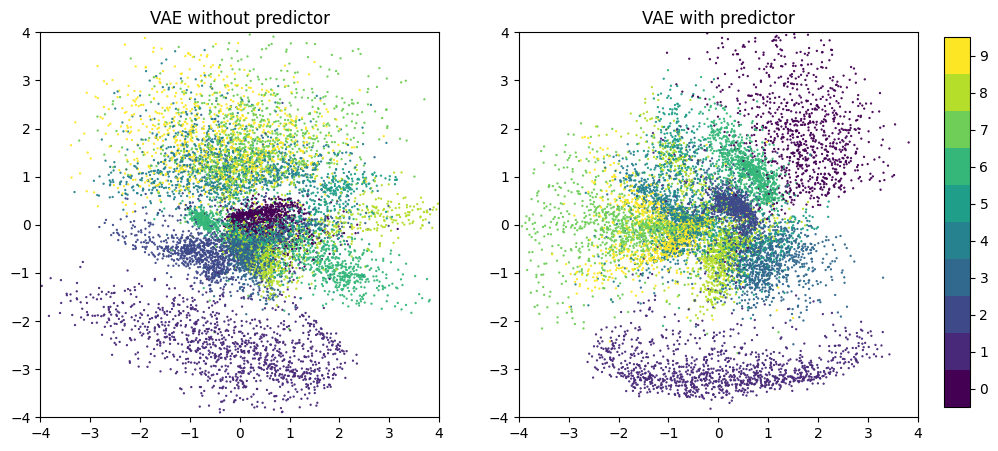

In [22]:
fig = plt.figure(figsize=(13, 5))
cmap = plt.get_cmap('viridis', 10)
ts = [vae_no_predictor, vae_with_predictor]
titles = ['VAE without predictor', 'VAE with predictor']
for i, t in enumerate(ts):
    plt.subplot(1, 2, i+1)
    latent_test, y_test = get_latents(t)
    im = plt.scatter(latent_test[:,0], latent_test[:,1], c=y_test, cmap=cmap, marker='o', s=0.4,  vmin=-0.5, vmax=9.5, )
    plt.title(titles[i])
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
fig.subplots_adjust(right=0.8)
fig.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10));